# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in Turi Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
SEED = 100

## Load LendingClub dataset

In [3]:
loans = pd.read_csv('lending-club-data.csv')

# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop(['bad_loans'], axis=1)

C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Selecting features

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

### Skipping observations with missing values

In [5]:
loans = loans[[target] + features]
loans.shape

(122607, 25)

In [6]:
loans =  loans.dropna()
loans.shape

(122578, 25)

### Subsample dataset to make sure classes are balanced

In [7]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

print("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46294


### Transform categorical data into binary features

In [8]:
# list to obtain the string features and remove them in the end
col_1hot = ['grade','home_ownership','purpose']

for feature in col_1hot:
    newfeature = pd.get_dummies(loans_data[feature], columns=[feature], prefix=feature, drop_first=True)
    loans_data = loans_data.join(newfeature)
    
loans_data = loans_data.drop(col_1hot, axis=1)
loans_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.57170,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
7,-1,1.0,1,1,18.08,9.71600,0.0,1.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
10,-1,0.2,1,1,10.08,12.21520,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
12,-1,0.4,0,4,7.06,3.90888,0.0,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110720,1,0.2,0,11,6.19,3.67527,0.0,1.0,3.0,1,...,0,1,0,0,0,0,0,0,0,0
42556,1,0.6,0,11,7.22,3.06554,0.0,1.0,0.0,0,...,1,0,0,0,0,0,0,0,0,0
56203,1,0.2,0,3,15.77,5.55700,1.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
17572,1,0.2,0,5,13.89,7.18783,0.0,1.0,0.0,0,...,1,0,0,0,0,0,0,0,0,0


### Split data into training and validation sets

In [9]:
new_features = list(loans_data.columns)
new_features.remove(target)
new_features

['sub_grade_num',
 'short_emp',
 'emp_length_num',
 'dti',
 'payment_inc_ratio',
 'delinq_2yrs',
 'delinq_2yrs_zero',
 'inq_last_6mths',
 'last_delinq_none',
 'last_major_derog_none',
 'open_acc',
 'pub_rec',
 'pub_rec_zero',
 'revol_util',
 'total_rec_late_fee',
 'int_rate',
 'total_rec_int',
 'annual_inc',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [10]:
X = loans_data[new_features]
y = loans_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [11]:
train_data, validation_data = train_test_split(loans_data, train_size=.8, random_state=SEED)

## Gradient boosted tree classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [13]:
DT_stump = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=SEED).fit(X_train, y_train)
model_5 = AdaBoostClassifier(base_estimator=DT_stump, n_estimators=5, random_state=SEED).fit(X_train, y_train)

### Prediction

In [14]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
2179,1,0.4,0,2,13.93,9.88099,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
79537,1,0.8,0,6,14.67,2.68217,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
80613,-1,0.2,0,8,14.97,11.41660,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
63663,-1,0.6,0,3,21.67,14.14490,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [15]:
print(model_5.predict(sample_validation_data[new_features]))
print(sample_validation_data[target])

[-1  1 -1 -1]
2179     1
79537    1
80613   -1
63663   -1
Name: safe_loans, dtype: int64


In [16]:
print(model_5.predict_proba(sample_validation_data[new_features]))

[[0.52546132 0.47453868]
 [0.44457309 0.55542691]
 [0.54385288 0.45614712]
 [0.54385288 0.45614712]]


In [17]:
y_pred = model_5.predict(X_test)
    
f1_Boost = f1_score(y_test,y_pred)
precision_Boost = precision_score(y_test,y_pred)
recall_Boost = recall_score(y_test,y_pred)
accuracy_Boost = accuracy_score(y_test,y_pred)

print("Model Evaluation Metrics Using Untouched Test Dataset")
print("*****************************************************")
print("F1 Score:  "+"{:.2f}".format(f1_Boost))
print("Precision: "+"{:.2f}".format(precision_Boost))
print("Recall: "+"{:.2f}".format(recall_Boost))
print("Accuracy:  "+"{:.2f}".format(accuracy_Boost))
print("*****************************************************")
print("Confusion Metrix:\n",confusion_matrix(y_test,y_pred))
print("*****************************************************")

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
F1 Score:  0.66
Precision: 0.62
Recall: 0.70
Accuracy:  0.64
*****************************************************
Confusion Metrix:
 [[2719 1963]
 [1352 3225]]
*****************************************************


### Effect of adding more trees

In [18]:
sizes = [10, 50, 100, 200, 500]

In [19]:
train_error = []
test_error = []
for i in sizes:
    clf = AdaBoostClassifier(base_estimator=DT_stump, n_estimators=i, random_state=SEED).fit(X_train, y_train)
    
    # train error
    y_pred_train = clf.predict(X_train)
    train_error.append(1 - accuracy_score(y_train, y_pred_train))
    
    # test error
    y_pred_test = clf.predict(X_test)
    test_error.append(1 - accuracy_score(y_test, y_pred_test))

    

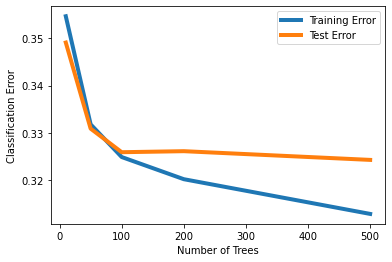

In [20]:
plt.figure()
plt.plot(sizes, train_error, linewidth=4.0, label='Training Error')
plt.plot(sizes, test_error, linewidth=4.0, label='Test Error')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend(loc='best')
plt.show()